# Countermeasures model v2

Changes:
* Fixed convolution by creating a tested library version
* Cleared up import code, removed obsolete mask, added text cells
* Improve plotting & writeouts
* Renamed from "basic" to v1 (this is hardly a simple model)
* Move most code to library (WIP)

Model v2:
* Add country unreliability parameter, used as scale multiplier in growth rate and measurement noise.

## Import & initialization

In [14]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
import pandas as pd
import pymc3 as pm
from datetime import datetime
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models import cm_effect

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data and parameter settings

In [6]:
Regions = ["NL"]#['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
Features = ['Gatherings limited to', 'Business suspended',
       'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Minor distancing and hygiene measures',
       'Phone line', 'Asymptomatic contact isolation']
#'Mask wearing' - has NaNs 
data = cm_effect.Loader('2020-02-29', '2020-04-04', Regions, Features)

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']


## Create, run and plot stability of model V2

CM delay: mean 6.959979582552529, len 16, cut at 10
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
CMReduction_log__           11.07
BaseGrowthRate_log__        -1.75
RegionGrowthRate_log__       0.29
RegionScaleMult_log__       -0.92
RealGrowth_log__            49.81
InitialSize_log__           -3.22
Observed_missing             0.00
Observed                 -1792.52
Name: Log-probability of test_point, dtype: float64
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, RealGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, RealGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 65 divergences: 100%|██████████| 3000/3000 [00:29<00:00, 103.45draws/s]
There were 32 divergences after tunin

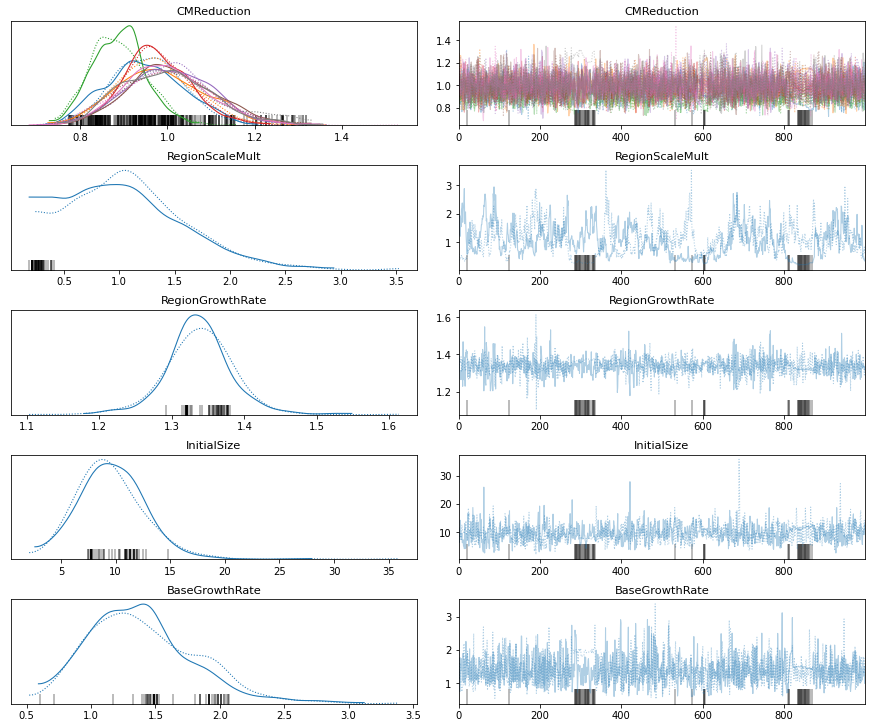

In [7]:
with cm_effect.CMModelV2(data, delay_mean=7.0) as model2:
    model2.build()
model2.run(1000)
_ = model2.plot_traces()

## Create, run and plot stability of model V2g (gauss prior)

CM delay: mean 5.978229043567663, len 15, cut at 9
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
CMReductionGamma_log__      -1.42
BaseGrowthRate_log__        -1.75
RegionGrowthRate_log__       0.29
RegionScaleMult_log__       -0.92
RealGrowth_log__            49.81
InitialSize_log__           -3.22
Observed_missing             0.00
Observed                 -3029.62
Name: Log-probability of test_point, dtype: float64
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, RealGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReductionGamma]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, RealGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReductionGamma]
Sampling 2 chains, 424 divergences: 100%|██████████| 3000/3000 [00:24<00:00, 124.10draws/s]
There were 401 divergences 

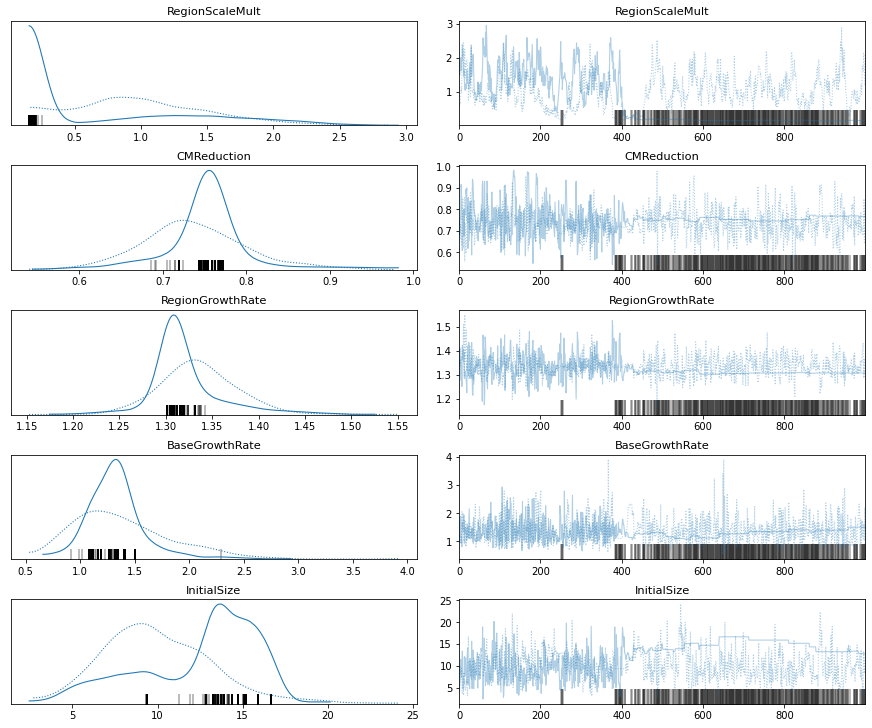

In [4]:
with cm_effect.CMModelV2g(data, delay_mean=6.0) as model2g:
    model2g.build()
model2g.run(1000)
_ = model2g.plot_traces()

## Plot inferred countermeasure effect

Effects are multiplicative (e.g. for a countermeasure that is a strenghtening of another, the inferred strenght is the additional multiplier).

The countermeasure strength is the multiplicative effect at feature=1.0.

0 Gatherings limited to          CMReduction          0.856 std=0.076 (0.737 .. 0.986)


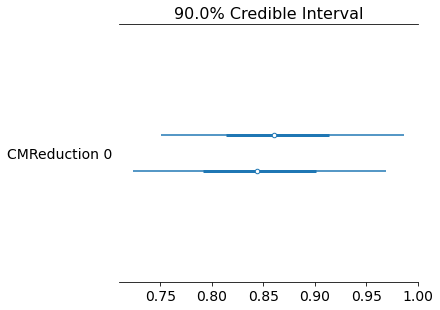

In [5]:
_ = model2.plot_CMReduction()
model2.print_CMReduction()

In [28]:
import plotly
from plotly import graph_objects as go
import plotly.express as px
import datetime



def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
fig = go.FigureWidget()
trace['RealGrowth']
for i, c in enumerate(Regions):
    d = trace['RealGrowth'][:,i,:]
    color = (px.colors.qualitative.Dark24 * 10)[i]
    plot_line_CIs(fig, data.Ds, d, c, color)
datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plotly.io.write_html(fig, f'{datestr}_growth_estimated_v2.html', include_plotlyjs='cdn')
fig

FigureWidget({
    'data': [{'legendgroup': 'NL',
              'line': {'color': '#2E91E5'},
              'n…

In [19]:
trace = model2.trace
quantiles = range(10,100,10)
dates = [datetime.date() for datetime in data.Ds]
index = pd.MultiIndex.from_product([Regions, dates], names=('Region', 'Date'))
df = pd.DataFrame(columns=['q'+str(q) for q in quantiles], index=index)
for i, country in enumerate(Regions):
    for j, date in enumerate(dates):
        ys = trace['RealGrowth'][j,i,:]
        for date in data.Ds:
            df.loc[(country, date.date().isoformat())] = [np.quantile(ys, q/100) for q in quantiles]

datestr = datetime.now().strftime("%Y-%m-%d")
df.to_csv(f'../out/growth_{datestr}.csv')